1. Distributed state management and design alternatives
1. consistency model
1. "Distributed Shared memory: Concepts and Systems"

 1. must decide placement
     1. place memory (pages) close to relevant processes
 1. Must decide migration
     1. when to copy memory (page) from remote to local
 1. must decide sharing rules
     1. ensure memory operations are properly ordered

### Review DFSs
1. clients:
    1. send requests to file service
1. Caching
    1. improve performance (seen by clients) 
    1. scalability (supported by servers)
1. Servers
    1. own and manage state (files)
    1. provide service (file access)

### Peer Distributed Applications
1. no server/client difference
    1. the states of application is distributed across all nodes
    1. each node
        1. owns state
        1. provides service
    1. all nodes are peers
1. examples
    1. big data analytics
    1. web searches
    1. content sharing
    1. distributed shared memory
1. some of the nodes may be dedicated to perform management tasks
1. in "peer-to-peer" even overall control & management done by all)

### Distributed Shared memory (DSM)
1. manage memory across multiple nodes
1. application on top has the illusion that they are running on a shared memory machine
1. each node 
    1. owns state => memory
    1. provides service
        1. memory read/write from any node
        1. consistency protocols
1. permits scaling beyond single machine memory limiits
    1. pros:
        1. more shared memory at lower cost
    1. cons:
        1. slower overall memory access
        1. commodity interconnect technologies suuport this (RDMA remote direct memory access)

### Hardware vs Software DSM
1. Hardware support (expensive)
    1. relies on interconnect
    1. OS manages larger physical memory
        1. os can establish virtual to physical memory mapping on other nodes
    1. NICs translate remote memory accesses to messages
    1. NICs involved in all aspects of memory management ; support atomics..
1. software supported
    1. everything done by software
        1. detect which memory is local or remote
        1. send the messages to the right node
        1. accept messsage from other nodes
        1. involved in all apspects of memory sharing and management
    1. OS, or language runtime

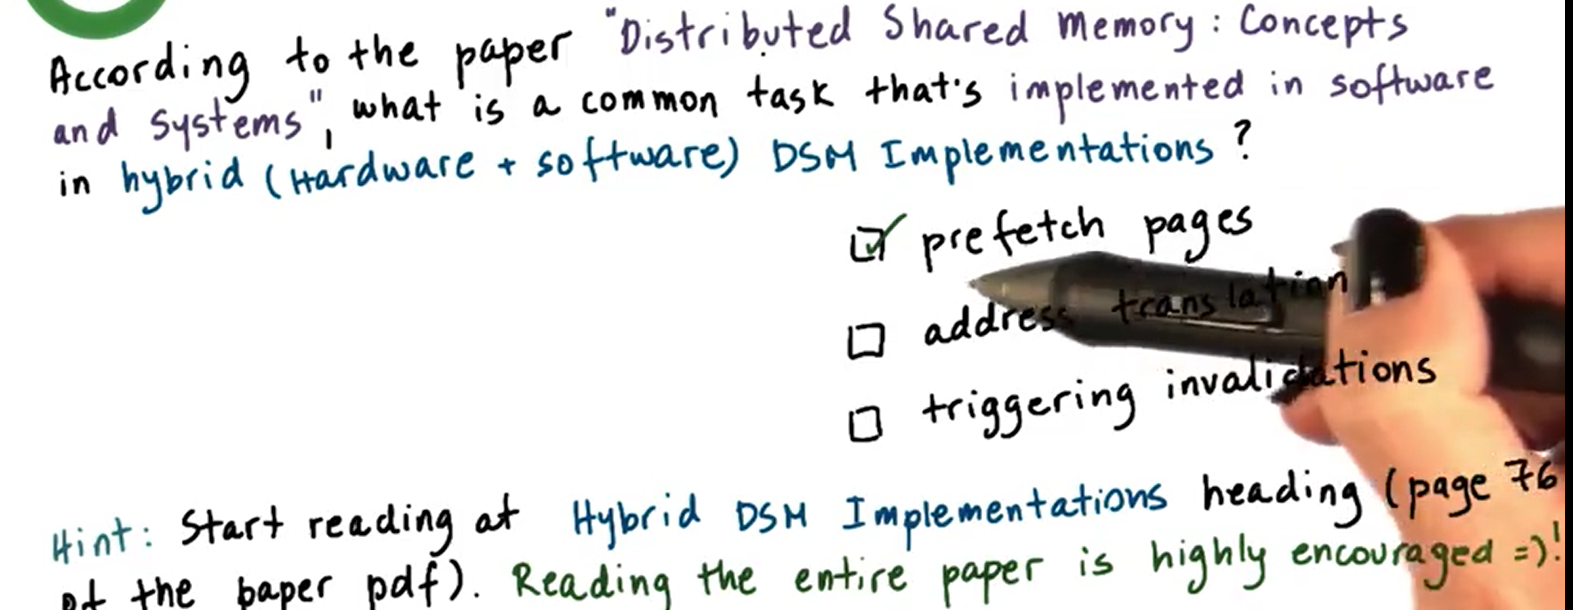
1. it depends on particular application on the access pattern
1. well defined and easier to implement in hardware
1. well defined and easier to implement in hardware

### DSM Design: Sharing Granularity
1. cache line granularity?  
    1. the hardware 
        1. track concurrent memory accesses at the grnularity of a single cache line
        1. triggers all the necessary coherence actions
    1. overheads too high for DSM
1. variable granularity
    1. some variables are too small => overheads too high
1. page granularity (OS level)
    1. OS track if page is modified => trigger messages
1. object granularity (language runtime)
    1. application level objects can be laid out on different pages
    1. we can fully reely on the page based OS level mechanism
    1. runtime can tell which object is local and which is remote
        1. OS doesn't need to know the DSM solution 
1. beaware of false sharing (trigger false sharing situation)
    1. x and y are on same page, but the clients don't need them both
    1. programmer be careful how data is allocated and laid out on pages or how it's grouped in higher level objects
    1. smart compiler able to understand what's is really shared state

### What types of applications use DSM
1. Application access algorithm
    1. single reader/single writer (SRSW)
        1. provide access to remote memory
        1. no challenge on consistence or sharing
    1. multi readers/single writer (MRSW)
    1. multi readers/multi writers (MRMW)

### Performance Considerations
1. DSM performance metric == access latency
1. achieving low latency through 
    1. migration
        1. makes sense for SRSW
        1. requires data movement 
    1. replication (caching)
        1. more general
        1. requires consistency management
            1. limit overhead =>limit the numbber of replica

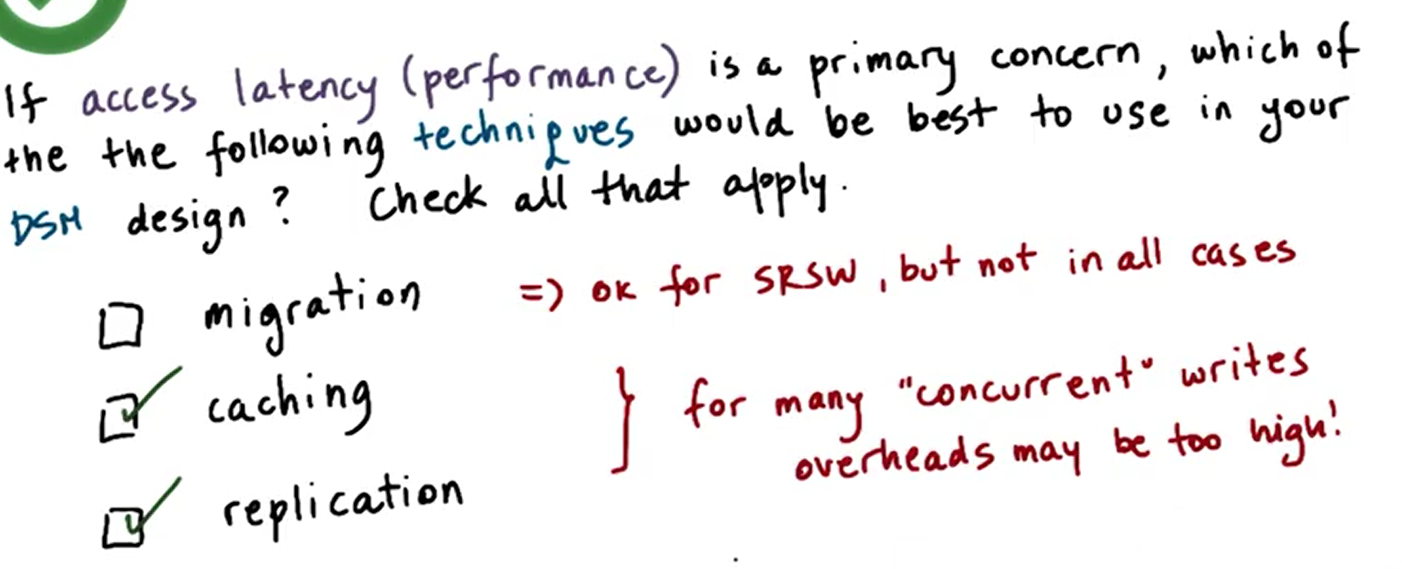


### DSM Design: Consistency Management
1. DSM should behave in a similar way as shared memeory in SMPs 
    1. in SMP
        1. write-invalidate
        1. write-update
        1. coherence operations triggeered on each write
            1. overhead too high for distributed system
1. Push invalidations when data is written to (done all by peers, no client server)
    1. proactive
    1. eager
    1. pessimistic
1. pull modification info 
    1. periodically
    1. on demand (reactive)
    1. lazy
    1. optimistic
1. when these methods get triggered depends on the consistency model for the shared state

### DSM Architecture (page-based, OS-supported)
1. paged-based DSM architecture
    1.distributed nodes, each with own local memory contribution (part or all of their physical memory)
    1. pool of pages from all nodes
    1. each page has ID o home node, page frame number
    1. if MRMW
        1. need local caches for performance (latency)
        1. home (or manager) node drives coherence operations
        1. all nodes responsible for part of distributed memory (state) management
    1. home node
        1. keeps state: pages accessed, modifications, caching enabled/disabled, locked...
        1. current "owner" (owner may not equal home node)
            1. owner node: 
                1. node owning the page (exclusive writer for example)
                1. can control all of the updates
                1. drive any consistency related operations
            1. home node:
                1. track who is the owner node on that page
    1. Explicit replicas
        1. for load balancing, performance, or reliabilty
        1. data center: current machine, nearby macihne, and a remote machine
        1. "home"/manager node controls management

### DSM Architecture Summary
Page-based DSM
1. each node contributes part of memory pages to DSM
1. need local caches for performance (latency)
1. all nodes responsible for part of distributed memory
1. home node manages accesses and track page ownership
1. explicit replication possible for load balancing, performance or reliability

### DSM Metadata
1. how to determine where is a particular page
1. each page (object) has
    1. address == node ID + page frame number
    1. node ID == "node" node
1. Global map (replicated)
    1. object (page) id => manager node id
    1. manager map avaiable on each node
    1. manager node: entity taht have the per-page or per-object metadata
1. Metadata for local pages (partitioned)
    1. metadata: necessary to  perform specific access to that page or to enforce consistency
    1. per page metadata is distributed across managers
1. fixed manager for every page
1. Global mapping table: (more flexible)
    1. object id => index into mapping table => manager node
    1. if we want to change who is the manage node for a particular object/page (like original manager failed/rebalance), we just need to update the mapping table
    1. no need to modify the object identifier

### Implementing DSMs
1. Problem: DSM must intercept accesses to DSM state
    1. to send remote messsages requesting access
    1. to trigger coherence message
    1. overhead should be avoided for local, non-shared state (pages)
    1. dynamically engage and disengage DSM when necessary
1. solution: use hardware MMU support
    1. trap in OS if mapping invalid or access not permitted
    1. remote address mapping => trap and pass to DSM to send message
        1. remote address is invalidated
    1. cached content => trap and pass to DSM to perform necessary coherence operations
        1. write-protected by DSM layer 
        1. modification cause trap
    1. other MMU information useful
        1. dirty page

### What is a cConsistency Model?
1. consistency model == agreement between memory (state) and upper software layers
    1. memeory behaves correctly if and only if software follows specific rules"
    1. memory (state) guarantees to behave correctly..
        1. access ordering: access will be corrected interleave
        1. propagation/visibilty of updates
1. notation:
    1. R_m1(x): X was read from memory location m1
    1. W_m1(y): Y was written to memory location m1
    1. initially all memory set to zero

### Strict Consistency
1. Strict consistency == update visible everywhere immediately
1. every single node in the system will see all the write in the exact same order as they were written (not affected by distance) 
1. in practice, 
    1. even on single SMP no guaranteeson order without extra locking and synchronization
    1. in distributed systems, latency & message reorder/loss make this even harder and impossible to guarantee

### Sequential Consistency
1. memory updates from different processors may be arbitrarily interleaved
1. as long as the odering observed is equivalent to some possible ordering of these operations if they executed on a single shared memory system, then that would be considered a legal operation according to the sequential consistency model
1. if we let one process see one ordering of these update, we have to make sure all othe processes see the exact same ordering of those updates
1. all processes will see the same interleaving
1. operations from same process always appear in order they were issued
1. constrain of interleaving: updates that are made by the same process will not be arbitrarily interleaved

### Causal consistency
1. guarantee they will detect the possible causal relationship between updates
1. if updates are causually related, then the memory will guarantee that those write/update operations will be correctly orderd
1. for writes not causally related, (concurrent writes in causal consistency), there are no guarantees
1. operations from same process always appear in order they were issued

### Weak Conssitency
1. synchronization points: operations that are avaiable (R, W, Sync)
    1. underlying system makes avaiable to the upper layers of the software
    1. all updates prior to a sync point on the other processors will be visible sebsequently at this processor in the future
    1. no guarantee what happens in between
    1. p1 perform sync doesn't guarantee p2 will see that update if p2 has not made an attempt to synchronize with the distributed shared memory
    1. sync has to be made both by the updating server ,and the server wanna see it
    1. once sync is performed in p2, p2 will be guaranteed that it will see all of the previous updates happened to any memory location in the system
1. variations
    1. single sync operation (sync) for all states
    1. separate sync per subste of state (page) 
    1. separate "entry/acquire" vs "exit/release" operations
        1. entry point: when a process requires that all the updats performed by other processors are visible to it (acquiring updates made by others)
            1. perform sync from other processors
        1. exit: release to other processes
    1. pros:
        1. limit data movement & coherence operation
    1. cons:
        1. maintain extra state for additional operations

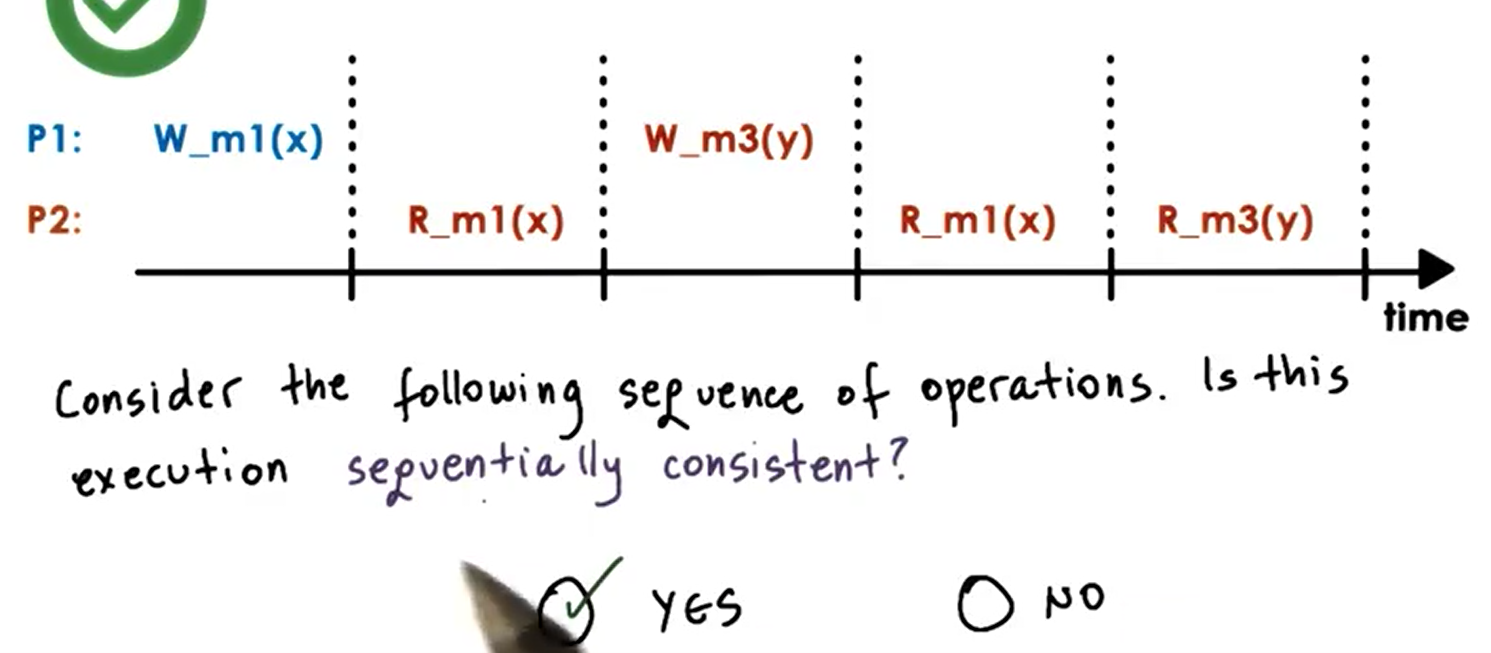

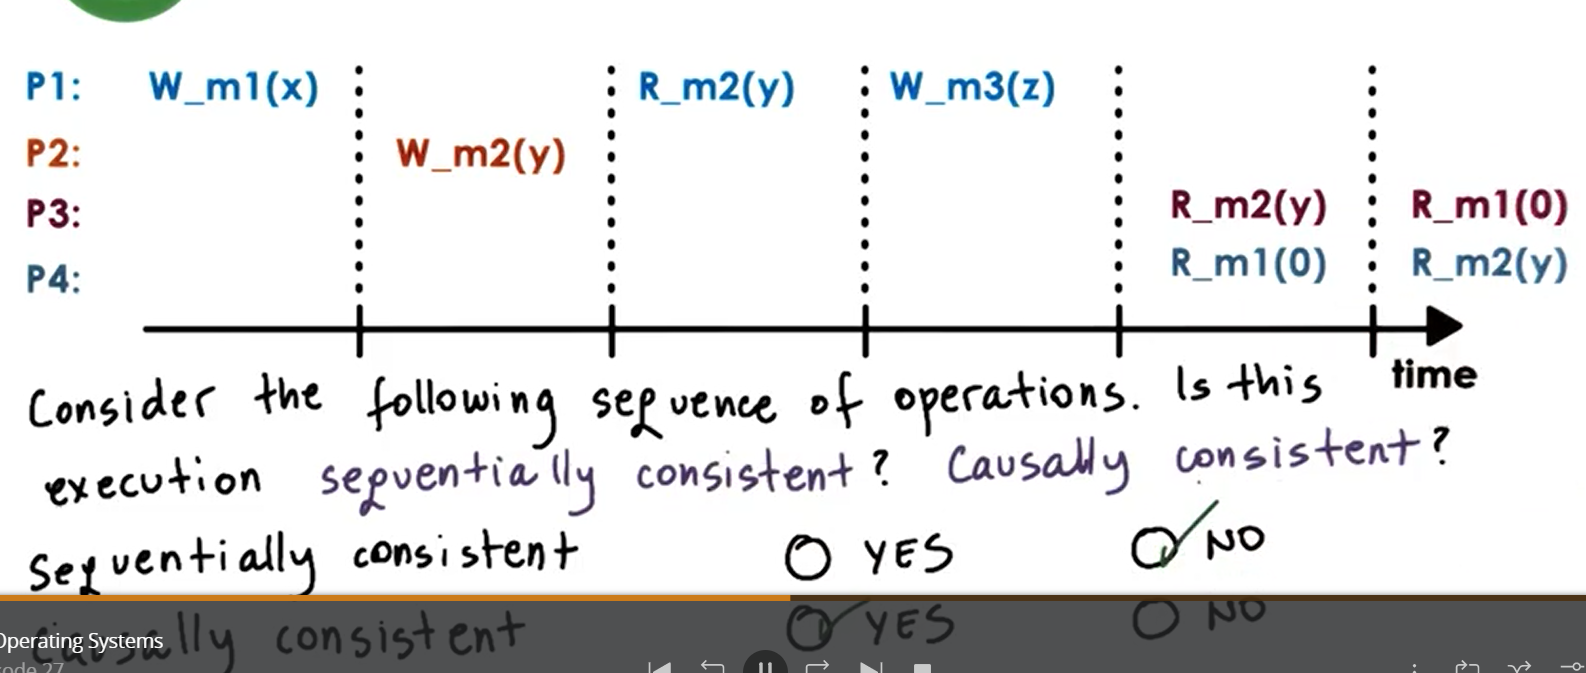

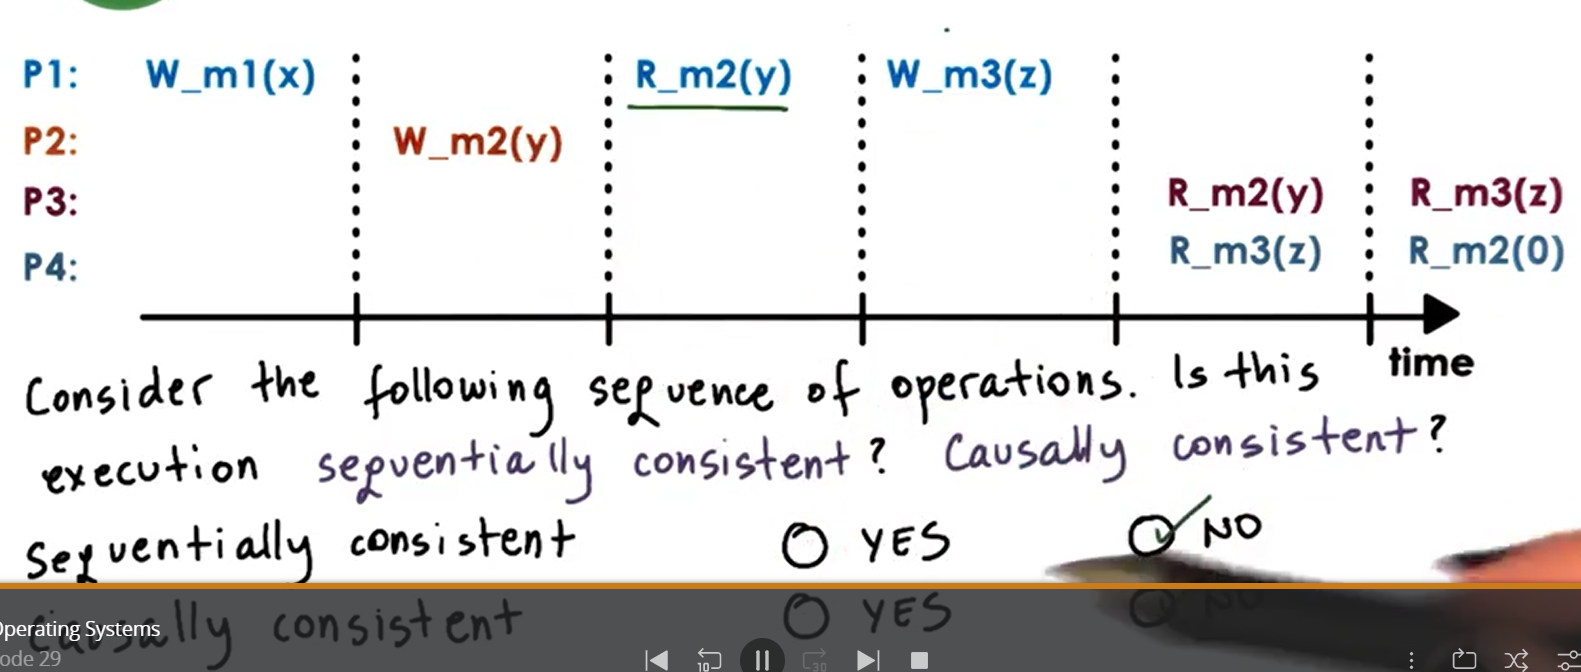

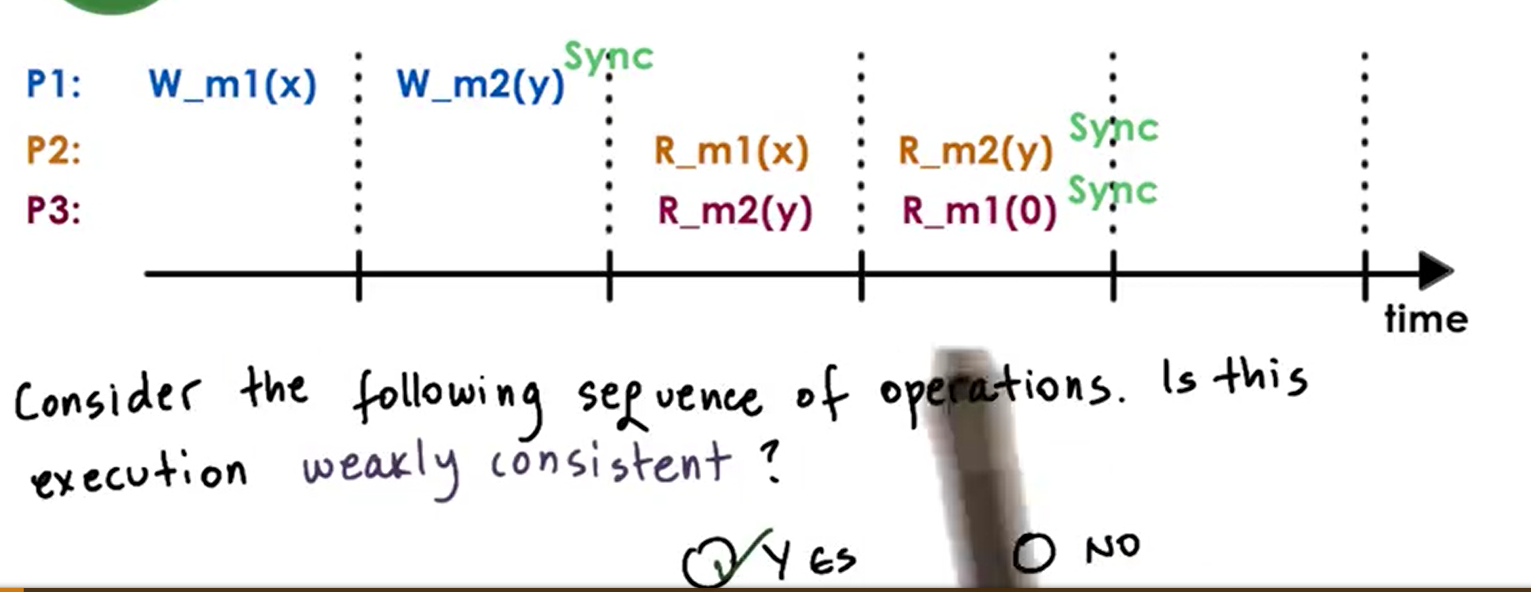

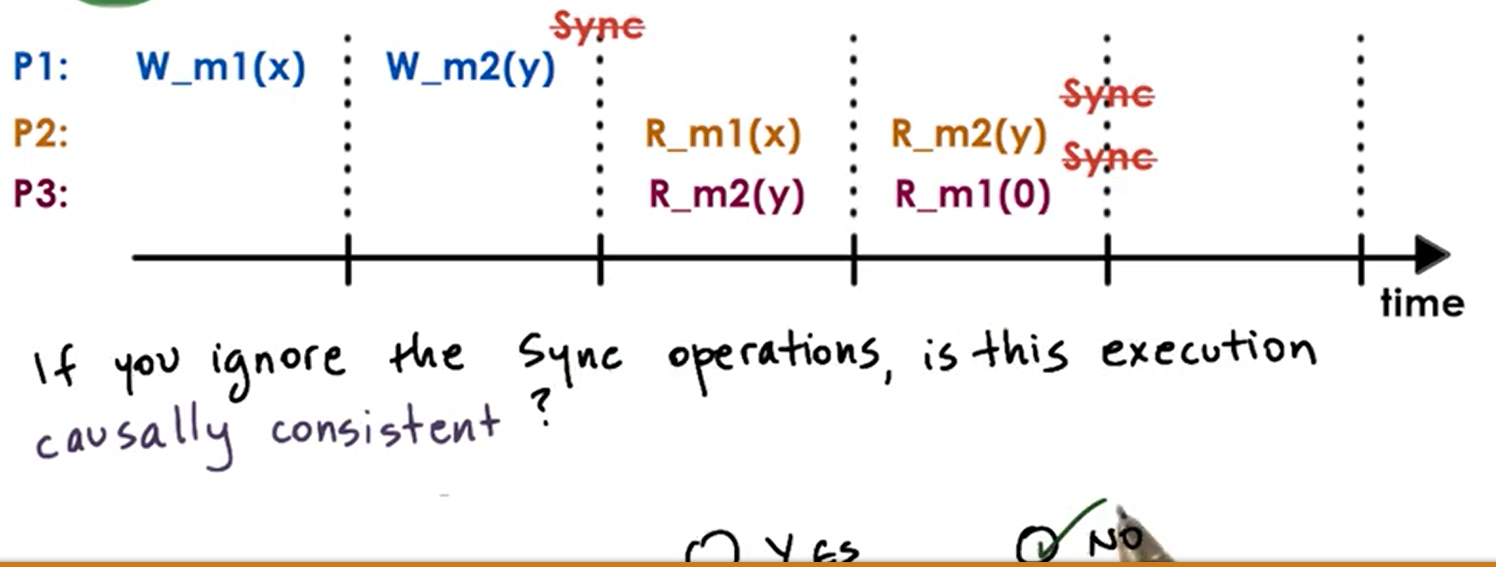